In [2]:
import pandas as pd
import numpy as np

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

# install the nsepy library to get stock prices
!pip install nsepy

############################################
# Getting Stock data using nsepy library
from nsepy import get_history
from datetime import datetime

startDate=datetime(2020, 1,1)
endDate=datetime(2022, 1, 1)

# Fetching the data
StockData=get_history(symbol='ONGC', start=startDate, end=endDate)
print(StockData.shape)
StockData.head()

(500, 14)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-01-01,ONGC,EQ,128.80,128.75,128.90,126.85,127.05,127.45,127.81,2574894,3.290880e+13,18298,770244,0.2991
2020-01-02,ONGC,EQ,127.45,127.65,128.65,127.10,128.10,128.05,127.85,4759843,6.085511e+13,29181,1985576,0.4172
2020-01-03,ONGC,EQ,128.05,131.00,133.40,128.05,128.10,128.45,130.41,31381588,4.092472e+14,135658,7628913,0.2431
2020-01-06,ONGC,EQ,128.45,129.70,129.80,125.10,126.30,126.25,127.20,14611204,1.858492e+14,82139,5005382,0.3426
2020-01-07,ONGC,EQ,126.25,125.60,127.70,125.40,125.75,125.75,126.31,7193304,9.086004e+13,46745,2003280,0.2785


<AxesSubplot:xlabel='TradeDate'>

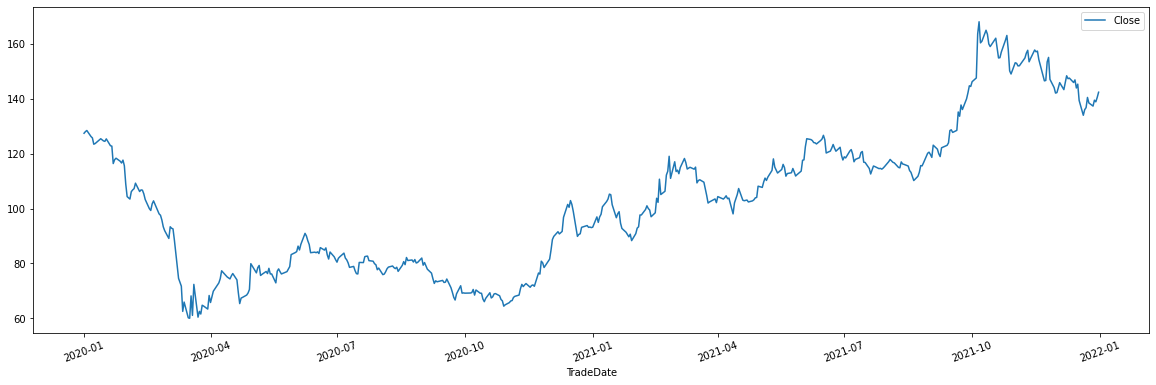

In [3]:
# Creating a column as date
StockData['TradeDate']=StockData.index

# Plotting the stock prices
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

In [4]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])

# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

print('### After Normalization ###')
X[0:5]

[[127.45]
 [128.05]
 [128.45]
 [126.25]
 [125.75]]
### After Normalization ###


array([[0.6239593 ],
       [0.62950971],
       [0.63320999],
       [0.61285846],
       [0.60823312]])

In [5]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(490, 10, 1)

#### Output Data shape ####
(490, 1)


In [6]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(485, 10, 1)
(485, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [7]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.6239593 ]
 [0.62950971]
 [0.63320999]
 [0.61285846]
 [0.60823312]
 [0.58695652]
 [0.5892692 ]
 [0.59343201]
 [0.60545791]
 [0.60175763]] -- [0.59805735]
[[0.62950971]
 [0.63320999]
 [0.61285846]
 [0.60823312]
 [0.58695652]
 [0.5892692 ]
 [0.59343201]
 [0.60545791]
 [0.60175763]
 [0.59805735]] -- [0.59666975]


In [8]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [9]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

##################################################

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
97/97 [==============================] - 2s 5ms/step - loss: 0.0790
Epoch 2/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0073
Epoch 3/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 4/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 5/100
97/97 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 6/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 7/100
97/97 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 8/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 9/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 10/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 11/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 12/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 13/100
97/97 [=================

In [ ]:
a = 

Accuracy: 99.25064504175874


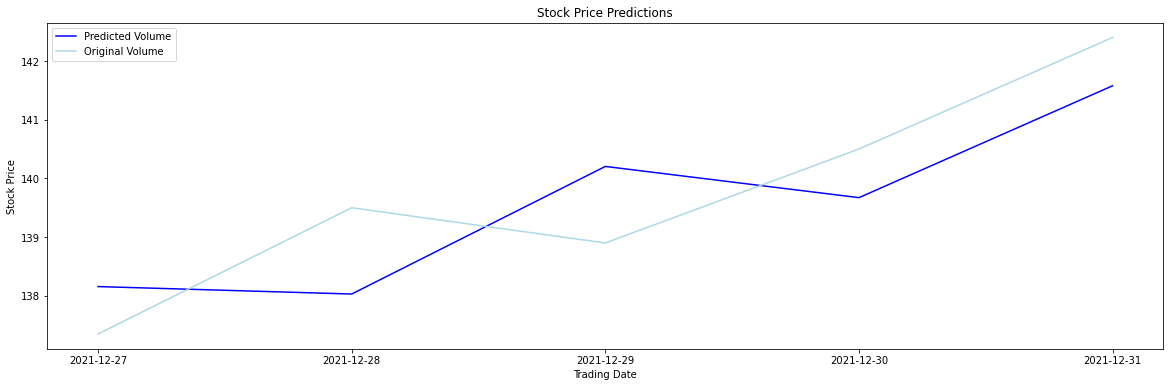

In [10]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

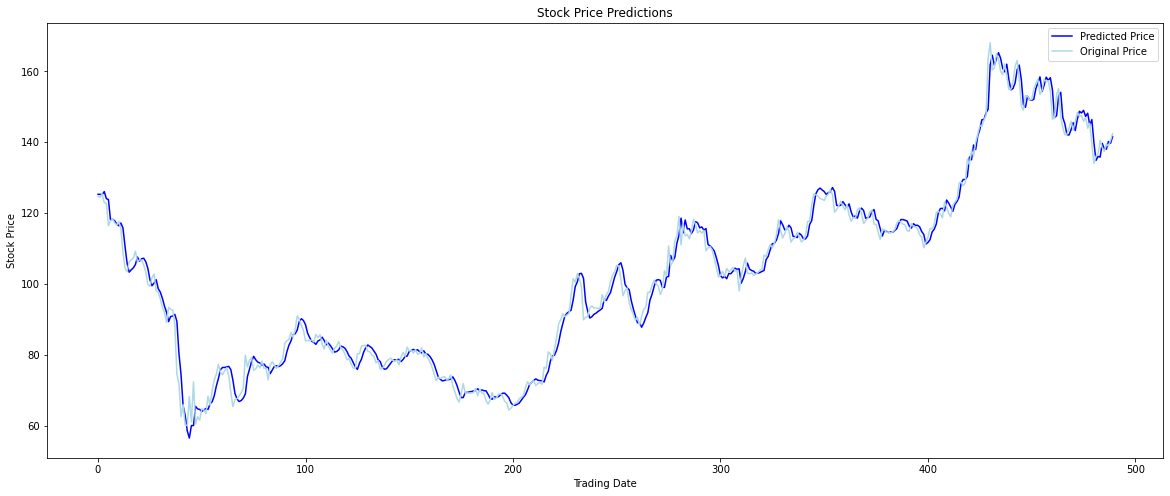

In [11]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [12]:
# Last 10 days prices
Last10Days=np.array([1002.15, 1009.9, 1007.5, 1019.75, 975.4,
            1011.45, 1010.4, 1009,1008.25, 1017.65])

# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))

# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)

#############################

# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[556.17365]], dtype=float32)